In [2]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from underthesea import word_tokenize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
test_dir = "/kaggle/input/news-data/Test_Full/Test_Full"

count_txt = 0
for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.endswith(".txt"):
            count_txt += 1

print("Tổng số file .txt trong test_dir:", count_txt)


Tổng số file .txt trong test_dir: 50373


In [4]:
import os

train_dir = "/kaggle/input/news-data/Train_Full"

count_txt = 0
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith(".txt"):
            count_txt += 1

print("Tổng số file .txt trong test_dir:", count_txt)


Tổng số file .txt trong test_dir: 33759


Bởi vì số lượng samples trong tập test khá lớn ( 33759 ) nên quyết định góp 2 tập train, test lại và chia lại theo tỷ lệ 9:1. 

In [5]:
texts = []
labels = []

train_dir = "/kaggle/input/news-data/Train_Full/Train_Full"
test_dir  = "/kaggle/input/news-data/Test_Full/Test_Full"

possible_encodings = ["utf-8", "utf-8-sig", "utf-16", "latin-1", "cp1252"]

def load_data_from_dir(base_dir):
    texts, labels = [], []
    for label in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, label)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                if filename.endswith(".txt"):
                    text = None
                    for enc in possible_encodings:
                        try:
                            with open(file_path, "r", encoding=enc) as f:
                                text = f.read()
                            break
                        except UnicodeDecodeError:
                            continue
                    if text is None:
                        print(f" Không đọc được file: {file_path}")
                        continue
                    texts.append(text)
                    labels.append(label)
    return texts, labels

train_texts, train_labels = load_data_from_dir(train_dir)
test_texts, test_labels   = load_data_from_dir(test_dir)

all_texts  = train_texts + test_texts
all_labels = train_labels + test_labels

print("Tổng số samples:", len(all_texts))

train_texts, val_texts, train_labels, val_labels = train_test_split(
    all_texts, all_labels, test_size=0.1, random_state=42, stratify=all_labels
)

print("Train:", len(train_texts))
print("Validation:", len(val_texts))
print("Ví dụ sample trong train:")
print("Label:", train_labels[0])
print("Text:", train_texts[0][:200])


Tổng số samples: 84132
Train: 75718
Validation: 8414
Ví dụ sample trong train:
Label: Van hoa
Text: Lâm Tâm Như: 'Tôi không rao bán sự gợi cảm'
Tôi biết nhiều người không thích hình ảnh mới của tôi trong những trang phục gợi cảm. Xin khẳng định rằng tôi không rao bán sự gợi cảm. Đơn giản vì tôi thíc


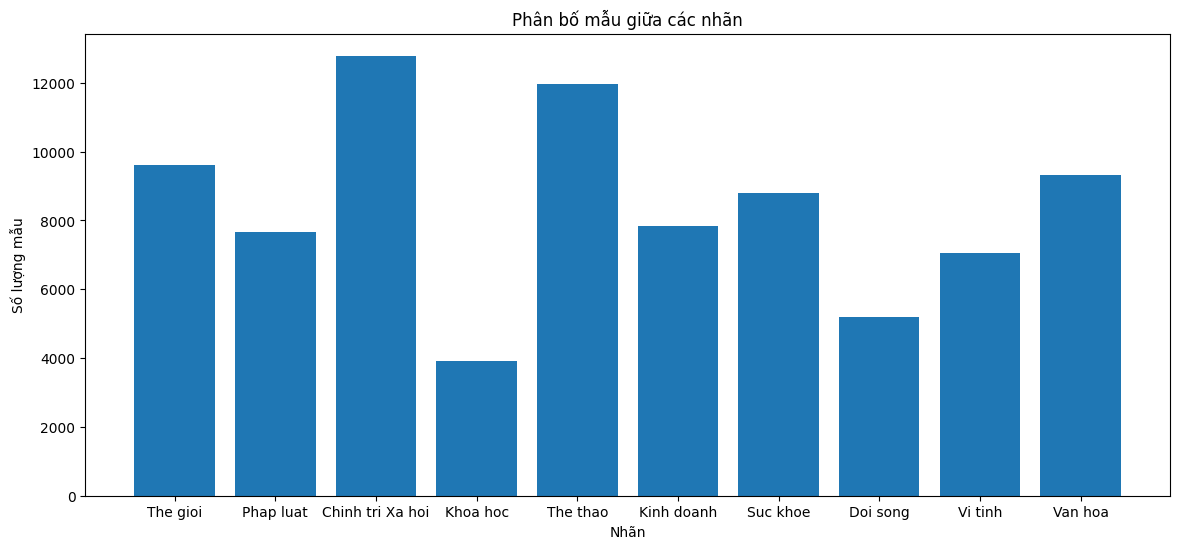

In [6]:
labels_count=Counter(all_labels)
plt.figure(figsize=(14,6))
plt.bar(labels_count.keys(), labels_count.values())
plt.title("Phân bố mẫu giữa các nhãn")
plt.xlabel("Nhãn")
plt.ylabel("Số lượng mẫu")
plt.show()

In [7]:
!pip install -q underthesea 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 67.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.9 MB/s eta 0:00:00


# Không tiền xử lý văn bản

In [9]:
def tokenize(text):
    tokens = word_tokenize(text, format="text")
    return tokens.lower().split()

all_tokens = []
for doc in train_texts:
    all_tokens.extend(tokenize(doc))

counter = Counter(all_tokens)
most_common = counter.most_common(10000 - 2)  # trừ <PAD>, <UNK>
vocab = {"<PAD>": 0, "<UNK>": 1}
for idx, (word, _) in enumerate(most_common, start=2):
    vocab[word] = idx

vocab_size = len(vocab)

# ------------------------
# 2. Encode dữ liệu
# ------------------------
def encode(text, max_len=200):
    tokens = tokenize(text)
    ids = [vocab.get(t, 1) for t in tokens]  # 1 = <UNK>
    if len(ids) < max_len:
        ids += [0] * (max_len - len(ids))  # padding
    else:
        ids = ids[:max_len]
    return ids

X_train = [encode(doc) for doc in train_texts]
X_val   = [encode(doc) for doc in val_texts]

label2id = {l: i for i, l in enumerate(set(all_labels))}
y_train = [label2id[l] for l in train_labels]
y_val   = [label2id[l] for l in val_labels]

X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_val   = torch.tensor(X_val)
y_val   = torch.tensor(y_val)

class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = NewsDataset(X_train, y_train)
val_dataset   = NewsDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64)

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        embedded = self.embedding(x)       
        pooled = embedded.mean(dim=1)     
        hidden = self.relu(self.fc1(pooled))
        output = self.fc2(hidden)
        return output

embed_dim = 200
hidden_dim = 128
num_classes = len(label2id)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = TextClassifier(vocab_size, embed_dim, hidden_dim, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # << đưa dữ liệu lên GPU
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)
    val_loss /= len(val_loader)
    val_acc = correct / total

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Using device: cuda
Epoch 1 | Train Loss: 0.7318 | Val Loss: 0.4132 | Val Acc: 0.8605
Epoch 2 | Train Loss: 0.3222 | Val Loss: 0.3372 | Val Acc: 0.8899
Epoch 3 | Train Loss: 0.2549 | Val Loss: 0.3171 | Val Acc: 0.8980
Epoch 4 | Train Loss: 0.2139 | Val Loss: 0.3004 | Val Acc: 0.9016
Epoch 5 | Train Loss: 0.1831 | Val Loss: 0.2999 | Val Acc: 0.9052


In [14]:
X_val_eval = [encode(doc) for doc in val_texts]
y_val_eval = [label2id[l] for l in val_labels]

X_val_eval = torch.tensor(X_val_eval).to(device)  
y_val_eval = torch.tensor(y_val_eval).to(device) 

model.eval()
with torch.no_grad():
    outputs = model(X_val_eval) 
    preds = torch.argmax(outputs, dim=1)

acc = (preds == y_val_eval).sum().item() / len(y_val_eval)
print(f"Validation Accuracy (dự đoán từ val_texts): {acc:.4f}")


Validation Accuracy (dự đoán từ val_texts): 0.9035


Classification Report:
                  precision    recall  f1-score   support

      Kinh doanh       0.88      0.92      0.90       783
        The thao       0.98      0.98      0.98      1197
        Doi song       0.78      0.77      0.78       519
        Khoa hoc       0.81      0.83      0.82       392
Chinh tri Xa hoi       0.85      0.87      0.86      1279
        Suc khoe       0.91      0.92      0.92       880
         Vi tinh       0.93      0.92      0.92       704
        The gioi       0.95      0.92      0.94       961
         Van hoa       0.93      0.92      0.92       933
       Phap luat       0.92      0.87      0.90       766

        accuracy                           0.90      8414
       macro avg       0.89      0.89      0.89      8414
    weighted avg       0.90      0.90      0.90      8414



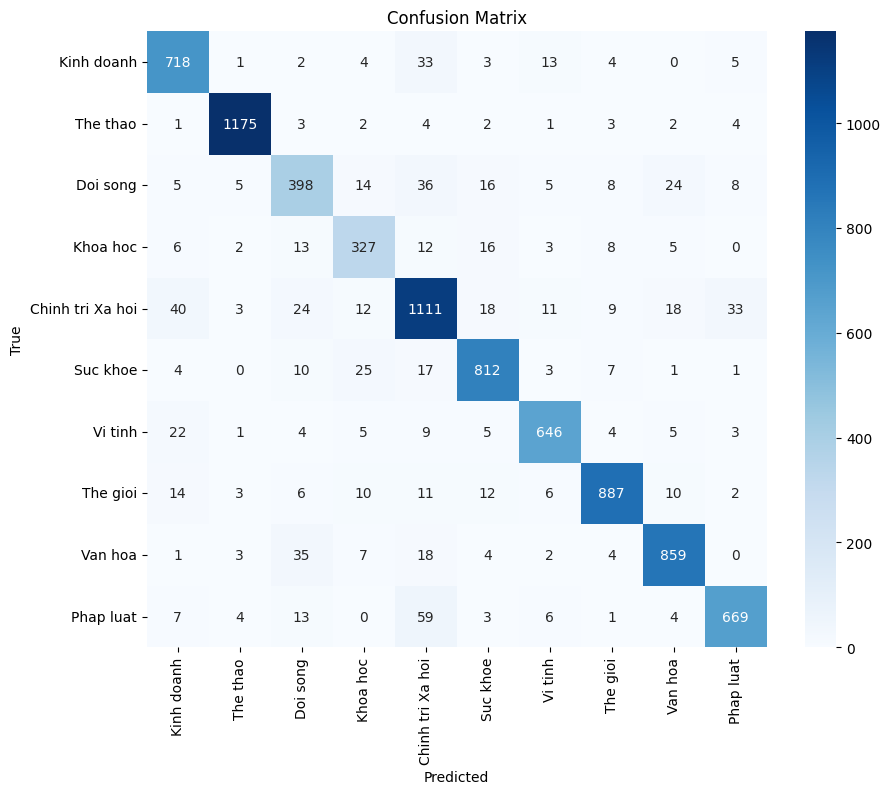

In [17]:
y_true = y_val_eval.cpu().numpy()
y_pred = preds.cpu().numpy()

id2label = {v: k for k, v in label2id.items()}
print("Classification Report:")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=[id2label[i] for i in range(num_classes)]
))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=[id2label[i] for i in range(num_classes)],
    yticklabels=[id2label[i] for i in range(num_classes)]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Có tiền xử lý văn bản

In [18]:

# Preprocessing
def clean_text(text: str) -> str:
    text = str(text).lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)  
    text = re.sub(r'[^0-9a-zA-ZÀ-Ỵà-ỵ\s]', ' ', text) 
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-ZÀ-Ỵà-ỵ\s]', ' ', text)
    return text.strip()

def tokenize(text: str):
    text = clean_text(text)  
    tokens = word_tokenize(text, format="text")
    return tokens.lower().split()

all_tokens = []
for doc in train_texts:
    all_tokens.extend(tokenize(doc))

counter = Counter(all_tokens)
most_common = counter.most_common(10000 - 2)  # trừ <PAD>, <UNK>
vocab = {"<PAD>": 0, "<UNK>": 1}
for idx, (word, _) in enumerate(most_common, start=2):
    vocab[word] = idx

vocab_size = len(vocab)

def encode(text, max_len=200):
    tokens = tokenize(text)   
    ids = [vocab.get(t, 1) for t in tokens]
    if len(ids) < max_len:
        ids += [0] * (max_len - len(ids)) 
    else:
        ids = ids[:max_len]
    return ids

X_train = [encode(doc) for doc in train_texts]
X_val   = [encode(doc) for doc in val_texts]

label2id = {l: i for i, l in enumerate(set(all_labels))}
y_train = [label2id[l] for l in train_labels]
y_val   = [label2id[l] for l in val_labels]

X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_val   = torch.tensor(X_val)
y_val   = torch.tensor(y_val)

class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = NewsDataset(X_train, y_train)
val_dataset   = NewsDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64)

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        embedded = self.embedding(x)       # (batch, seq_len, embed_dim)
        pooled = embedded.mean(dim=1)      # mean pooling
        hidden = self.relu(self.fc1(pooled))
        output = self.fc2(hidden)
        return output

embed_dim = 200
hidden_dim = 128
num_classes = len(label2id)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = TextClassifier(vocab_size, embed_dim, hidden_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)

    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)
    val_loss /= len(val_loader)
    val_acc = correct / total

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Using device: cuda
Epoch 1 | Train Loss: 0.7105 | Val Loss: 0.3905 | Val Acc: 0.8756
Epoch 2 | Train Loss: 0.3156 | Val Loss: 0.3334 | Val Acc: 0.8914
Epoch 3 | Train Loss: 0.2518 | Val Loss: 0.3194 | Val Acc: 0.8949
Epoch 4 | Train Loss: 0.2112 | Val Loss: 0.3246 | Val Acc: 0.8916
Epoch 5 | Train Loss: 0.1807 | Val Loss: 0.3101 | Val Acc: 0.8997


In [20]:
X_val_eval = [encode(doc) for doc in val_texts]
y_val_eval = [label2id[l] for l in val_labels]

X_val_eval = torch.tensor(X_val_eval).to(device)   
y_val_eval = torch.tensor(y_val_eval).to(device)  

model.eval()
with torch.no_grad():
    outputs = model(X_val_eval) 
    preds = torch.argmax(outputs, dim=1)

acc = (preds == y_val_eval).sum().item() / len(y_val_eval)
print(f"Validation Accuracy (dự đoán từ val_texts): {acc:.4f}")


Validation Accuracy (dự đoán từ val_texts): 0.8997


Classification Report:
                  precision    recall  f1-score   support

      Kinh doanh       0.89      0.90      0.90       783
        The thao       0.99      0.97      0.98      1197
        Doi song       0.75      0.77      0.76       519
        Khoa hoc       0.82      0.79      0.81       392
Chinh tri Xa hoi       0.81      0.90      0.85      1279
        Suc khoe       0.92      0.90      0.91       880
         Vi tinh       0.94      0.92      0.93       704
        The gioi       0.97      0.90      0.93       961
         Van hoa       0.92      0.94      0.93       933
       Phap luat       0.92      0.87      0.89       766

        accuracy                           0.90      8414
       macro avg       0.89      0.89      0.89      8414
    weighted avg       0.90      0.90      0.90      8414



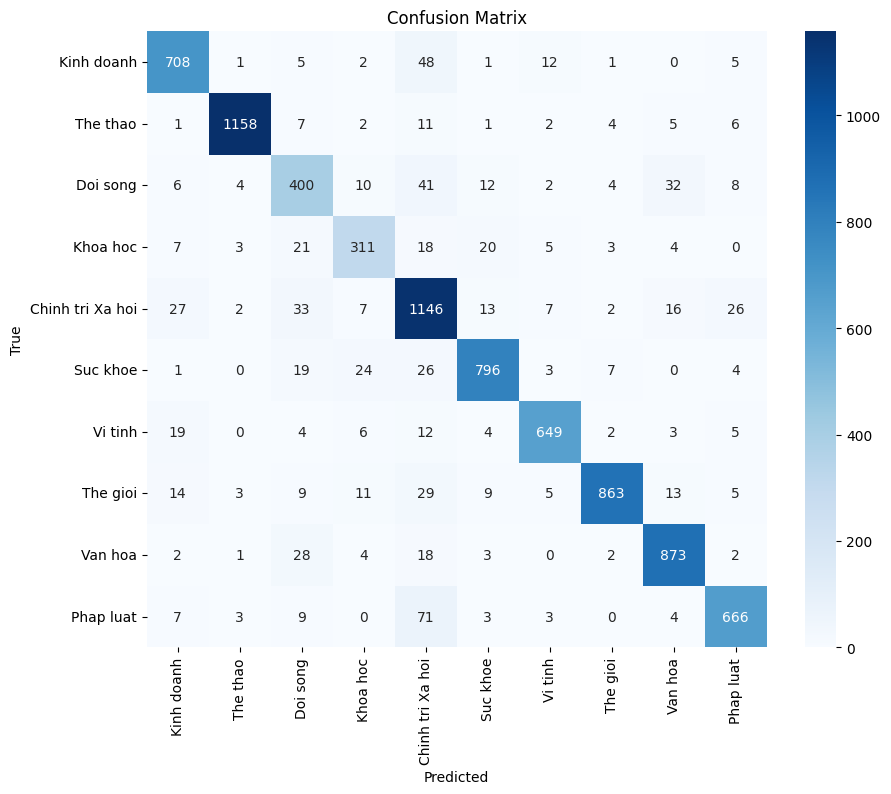

In [21]:
y_true = y_val_eval.cpu().numpy()
y_pred = preds.cpu().numpy()

id2label = {v: k for k, v in label2id.items()}
print("Classification Report:")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=[id2label[i] for i in range(num_classes)]
))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=[id2label[i] for i in range(num_classes)],
    yticklabels=[id2label[i] for i in range(num_classes)]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Minh họa Gradient Descent

In [1]:
# Hàm f(x) = 3*x^2 + 5*x - 7
theta = 10.0 
learning_rate = 0.05
max_iterations = 100
epsilon = 1e-5  # ngưỡng dừng

print("Step\tTheta\tf(Theta)\tGradient")
for i in range(max_iterations):
    gradient = 6*theta + 5
    f_val = 3*theta**2 + 5*theta - 7
    print(f"{i+1}\t{theta:.6f}\t{f_val:.6f}\t{gradient:.6f}")
    
    # Kiểm tra điều kiện dừng
    if abs(gradient) < epsilon:
        print(f"Hội tụ tại bước {i+1}")
        break

    # Cập nhật theta
    theta = theta - learning_rate * gradient


Step	Theta	f(Theta)	Gradient
1	10.000000	343.000000	65.000000
2	6.750000	163.437500	45.500000
3	4.475000	75.451875	31.850000
4	2.882500	32.338919	22.295000
5	1.767750	11.213570	15.606500
6	0.987425	0.862149	10.924550
7	0.441197	-4.210047	7.647185
8	0.058838	-6.695423	5.353029
9	-0.208813	-7.913257	3.747121
10	-0.396169	-8.509996	2.622984
11	-0.527318	-8.802398	1.836089
12	-0.619123	-8.945675	1.285262
13	-0.683386	-9.015881	0.899684
14	-0.728370	-9.050282	0.629779
15	-0.759859	-9.067138	0.440845
16	-0.781901	-9.075398	0.308591
17	-0.797331	-9.079445	0.216014
18	-0.808132	-9.081428	0.151210
19	-0.815692	-9.082400	0.105847
20	-0.820985	-9.082876	0.074093
21	-0.824689	-9.083109	0.051865
22	-0.827282	-9.083223	0.036305
23	-0.829098	-9.083280	0.025414
24	-0.830368	-9.083307	0.017790
25	-0.831258	-9.083320	0.012453
26	-0.831881	-9.083327	0.008717
27	-0.832316	-9.083330	0.006102
28	-0.832621	-9.083332	0.004271
29	-0.832835	-9.083333	0.002990
30	-0.832985	-9.083333	0.002093
31	-0.833089	-9.0833

Với hàm bậc 2 f(x) = ax^2 + bx + c thì sẽ có cực tiểu lại điểm -b/2a nên với hàm f(x) = 3*x^2 + 5*x - 7 sẽ có cực tiểu là -5/6, xấp xỉ với giá trị điểm được bằng Gradient Descent => Thuật toán chạy đúng